In [113]:
# Churn Modeling
# Load order data and label churn

# Import libraries
import pandas as pd 
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [88]:
# Load Order Data
orders = pd.read_csv(r"C:\Users\jakel\OneDrive\Desktop\Money Money Money\Fitness E-Commerce\orders.csv")

# Change OrderDate to datetime type
orders['OrderDate'] = pd.to_datetime(orders['OrderDate'])

In [89]:
# Total spent column

orders['TotalSpend'] = orders['Quantity'] * orders['UnitPrice'] - ( orders['Quantity'] * orders['UnitPrice'] * (orders['DiscountApplied'] / 100))

In [90]:
# Get last and first order dates for each customer
customer_orders = orders.groupby('CustomerID').agg(
    last_order_date=('OrderDate', 'max'),
    first_order_date=('OrderDate', 'min'),
    total_orders=('OrderDate', 'count'),
    total_spent=('TotalSpend', 'sum')
).reset_index()

customer_orders['last_order_date'] = pd.to_datetime(customer_orders['last_order_date'])
customer_orders['first_order_date'] = pd.to_datetime(customer_orders['first_order_date'])

In [91]:
# Set last day of 2024 as December 31, 2024. Change to date datatype
End2024 = '2024-12-31'
format_string = "%Y-%m-%d"
End2024 = datetime.strptime(End2024, format_string)

# Create new columns by calculating days since first and last orders
customer_orders['days_since_last_order'] = (End2024 - customer_orders['last_order_date']).dt.days
customer_orders['days_since_first_order'] = (End2024 - customer_orders['first_order_date']).dt.days

# Create new column by calculating avg days between first and last orders
customer_orders['avg_days_between_orders'] = customer_orders['days_since_first_order'] / customer_orders['total_orders']

# Create new column by calculating Average Order Value
customer_orders['aov'] = customer_orders['total_spent'] / customer_orders['total_orders']


In [92]:
# Create functiont o define customers as new, churned, or active
def label_status(row):
    if row['days_since_first_order'] <= 30:
        return 'New'
    elif row['days_since_last_order'] > 180:
        return 'Churned'
    else:
        return 'Active'

In [93]:
# Create status and churn labels by using function 'label_status'. Then, applying label if chruned.
customer_orders['status'] = customer_orders.apply(label_status, axis=1)
customer_orders['churn_label'] = customer_orders['status'].apply(lambda x: 1 if x == 'Churned' else 0)

In [94]:
# Prepare feature and labels
features = customer_orders[['total_orders', 'total_spent', 'days_since_last_order', 'days_since_first_order', 'avg_days_between_orders', 'aov']]
labels = customer_orders['churn_label']

In [95]:
# Create train/test split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

In [96]:
# Train Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [107]:
# Evaluate Model
y_prob = model.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_prob > 0.7).astype(int)
print(classification_report(y_test, y_pred_thresh))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        62
           1       1.00      1.00      1.00        84

    accuracy                           1.00       146
   macro avg       1.00      1.00      1.00       146
weighted avg       1.00      1.00      1.00       146



In [108]:
print(labels.value_counts())

churn_label
1    252
0    232
Name: count, dtype: int64


In [109]:
# Score all customers
customer_orders['churn_probability'] = model.predict_proba(features)[:, 1]

In [110]:
# Print sampling of churn probability
print(customer_orders[['CustomerID', 'status', 'churn_probability']].sort_values(by='churn_probability', ascending=True).head(50))

    CustomerID  status  churn_probability
483    CUST500  Active                0.0
204    CUST212  Active                0.0
392    CUST407  Active                0.0
398    CUST414  Active                0.0
399    CUST415  Active                0.0
414    CUST430  Active                0.0
416    CUST432  Active                0.0
166    CUST173  Active                0.0
165    CUST172  Active                0.0
163    CUST170  Active                0.0
419    CUST435  Active                0.0
146    CUST152  Active                0.0
145    CUST151  Active                0.0
139    CUST145  Active                0.0
212    CUST220  Active                0.0
127    CUST133  Active                0.0
120    CUST124  Active                0.0
118    CUST122  Active                0.0
109    CUST113  Active                0.0
108    CUST112  Active                0.0
104    CUST108  Active                0.0
99     CUST103  Active                0.0
96     CUST100  Active            

In [111]:
# Output full results to output.csv
customer_orders.to_csv('output.csv', index=False)

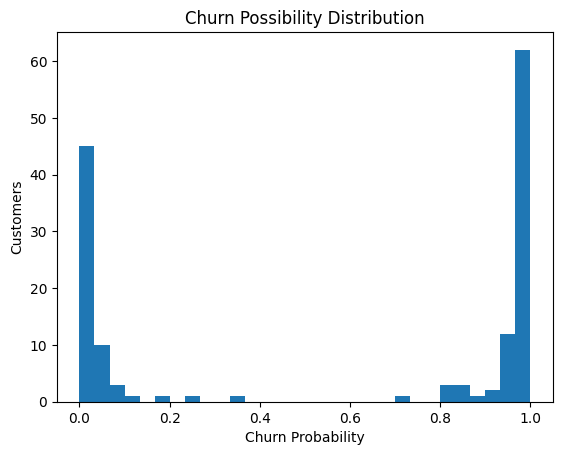

In [114]:
# Visualize churn probabilities distribution in histogran
plt.hist(y_prob, bins=30)
plt.title("Churn Possibility Distribution")
plt.xlabel("Churn Probability")
plt.ylabel("Customers")
plt.show()